# Predict People with multivariances

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Import data

In [2]:
import pandas as pd

path = '../data/num_file/hrs_1/p040.csv'
people = pd.read_csv(path, encoding='utf-8')

Merge "date" and "hour" columns to be datetime

In [3]:
people['datetime'] = pd.to_datetime(people['date'])+pd.to_timedelta(people['hour'], unit='h')
people = people.drop(['date', 'hour'], axis=1)
people.set_index('datetime', inplace=True)
people.columns = ['amount']
people['amount'] = people['amount'].astype(float)
print(people)

                      amount
datetime                    
2022-04-21 01:00:00   1033.0
2022-04-21 02:00:00     65.0
2022-04-21 12:00:00   1604.0
2022-04-25 15:00:00   4458.0
2022-04-25 16:00:00  18501.0
...                      ...
2022-09-03 07:00:00   9741.0
2022-09-03 08:00:00  19613.0
2022-09-03 09:00:00  22055.0
2022-09-03 10:00:00  14644.0
2022-09-03 11:00:00  12751.0

[3144 rows x 1 columns]


Resample the data that are not existed

In [4]:
full_index = pd.date_range(start=people.index.min(), end=people.index.max(), freq='h')
people = people.reindex(full_index)
people['amount'] = people['amount'].bfill()
print(people)

                      amount
2022-04-21 01:00:00   1033.0
2022-04-21 02:00:00     65.0
2022-04-21 03:00:00   1604.0
2022-04-21 04:00:00   1604.0
2022-04-21 05:00:00   1604.0
...                      ...
2022-09-03 07:00:00   9741.0
2022-09-03 08:00:00  19613.0
2022-09-03 09:00:00  22055.0
2022-09-03 10:00:00  14644.0
2022-09-03 11:00:00  12751.0

[3251 rows x 1 columns]


In [5]:
import calendar
from datetime import date
day = pd.DataFrame(people.index)
day = day.rename(columns={0: 'datetime'})
day['datetime'] = pd.to_datetime(day['datetime'])
print(day)

                datetime
0    2022-04-21 01:00:00
1    2022-04-21 02:00:00
2    2022-04-21 03:00:00
3    2022-04-21 04:00:00
4    2022-04-21 05:00:00
...                  ...
3246 2022-09-03 07:00:00
3247 2022-09-03 08:00:00
3248 2022-09-03 09:00:00
3249 2022-09-03 10:00:00
3250 2022-09-03 11:00:00

[3251 rows x 1 columns]


Import temperature data.

In [6]:
import os
import pandas as pd

folder_path = '../data/temperature_file/'

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

temperature = []

for file in csv_files:
    file_path = folder_path + file
    df = pd.read_csv(file_path, encoding='utf-8')
    temperature.append(df)

temperature = pd.concat(temperature, ignore_index=True)
    

In [7]:
temperature['datetime'] = pd.to_datetime(temperature['datetime'])
temperature.set_index('datetime', inplace=True)
print(temperature)

                     temperature  precipitation  weather
datetime                                                
2022-01-01 01:00:00         -3.6            0.5      NaN
2022-01-01 02:00:00         -3.6            0.0      NaN
2022-01-01 03:00:00         -3.4            0.0     12.0
2022-01-01 04:00:00         -3.7            0.0      NaN
2022-01-01 05:00:00         -4.1            1.0      NaN
...                          ...            ...      ...
2022-12-31 20:00:00          2.9            0.0      NaN
2022-12-31 21:00:00          1.8            0.0      1.0
2022-12-31 22:00:00          2.6            0.0      NaN
2022-12-31 23:00:00          1.9            0.0      NaN
2023-01-01 00:00:00          1.7            0.0      NaN

[8760 rows x 3 columns]


Merge the amount of people and temperature data as one dataframe.

In [8]:
data = pd.merge(people, temperature, left_index=True, right_index=True, how='inner')
print(data)

                      amount  temperature  precipitation  weather
2022-04-21 01:00:00   1033.0          9.2            0.0      NaN
2022-04-21 02:00:00     65.0          9.1            0.0      NaN
2022-04-21 03:00:00   1604.0          9.1            0.0      1.0
2022-04-21 04:00:00   1604.0          7.9            0.0      NaN
2022-04-21 05:00:00   1604.0          7.4            0.0      NaN
...                      ...          ...            ...      ...
2022-09-03 07:00:00   9741.0         22.4            0.0      NaN
2022-09-03 08:00:00  19613.0         22.8            0.0      NaN
2022-09-03 09:00:00  22055.0         23.2            0.0      4.0
2022-09-03 10:00:00  14644.0         23.4            0.0      NaN
2022-09-03 11:00:00  12751.0         23.7            0.0      NaN

[3251 rows x 4 columns]


## Data Preprocessing

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
data[['amount', 'temperature']] = scaler.fit_transform(data[['amount', 'temperature']])

In [11]:
print(data.head())

                       amount  temperature  precipitation  weather
2022-04-21 01:00:00 -1.608170    -2.122485            0.0      NaN
2022-04-21 02:00:00 -1.752224    -2.140183            0.0      NaN
2022-04-21 03:00:00 -1.523196    -2.140183            0.0      1.0
2022-04-21 04:00:00 -1.523196    -2.352552            0.0      NaN
2022-04-21 05:00:00 -1.523196    -2.441039            0.0      NaN


In [12]:
data = data[['amount', 'temperature']]
print(data)

                       amount  temperature
2022-04-21 01:00:00 -1.608170    -2.122485
2022-04-21 02:00:00 -1.752224    -2.140183
2022-04-21 03:00:00 -1.523196    -2.140183
2022-04-21 04:00:00 -1.523196    -2.352552
2022-04-21 05:00:00 -1.523196    -2.441039
...                       ...          ...
2022-09-03 07:00:00 -0.312280     0.213572
2022-09-03 08:00:00  1.156832     0.284362
2022-09-03 09:00:00  1.520241     0.355151
2022-09-03 10:00:00  0.417365     0.390546
2022-09-03 11:00:00  0.135656     0.443638

[3251 rows x 2 columns]


Slice into dataframe

In [13]:
window_size = 24
def one_step_forecast(df, window=6):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [14]:
test = one_step_forecast(data['amount'], window_size)

In [15]:
y = test['y']
test = test.drop('y', axis=1)
print(test)

                          x_1       x_2       x_3       x_4       x_5  \
2022-04-21 01:00:00 -1.608170 -1.752224 -1.523196 -1.523196 -1.523196   
2022-04-21 02:00:00 -1.752224 -1.523196 -1.523196 -1.523196 -1.523196   
2022-04-21 03:00:00 -1.523196 -1.523196 -1.523196 -1.523196 -1.523196   
2022-04-21 04:00:00 -1.523196 -1.523196 -1.523196 -1.523196 -1.523196   
2022-04-21 05:00:00 -1.523196 -1.523196 -1.523196 -1.523196 -1.523196   
...                       ...       ...       ...       ...       ...   
2022-09-02 07:00:00  0.285961  1.057721  0.334623  1.582000  2.100772   
2022-09-02 08:00:00  1.057721  0.334623  1.582000  2.100772  0.787768   
2022-09-02 09:00:00  0.334623  1.582000  2.100772  0.787768  1.724863   
2022-09-02 10:00:00  1.582000  2.100772  0.787768  1.724863  1.419492   
2022-09-02 11:00:00  2.100772  0.787768  1.724863  1.419492  0.644905   

                          x_6       x_7       x_8       x_9      x_10  ...  \
2022-04-21 01:00:00 -1.523196 -1.523196 -1.52

In [16]:
test_2 = one_step_forecast(data['temperature'], window_size)

In [17]:
test_2.drop('y', axis=1, inplace=True)
print(test_2)

                          x_1       x_2       x_3       x_4       x_5  \
2022-04-21 01:00:00 -2.122485 -2.140183 -2.140183 -2.352552 -2.441039   
2022-04-21 02:00:00 -2.140183 -2.140183 -2.352552 -2.441039 -2.246367   
2022-04-21 03:00:00 -2.140183 -2.352552 -2.441039 -2.246367 -1.821630   
2022-04-21 04:00:00 -2.352552 -2.441039 -2.246367 -1.821630 -1.308405   
2022-04-21 05:00:00 -2.441039 -2.246367 -1.821630 -1.308405 -0.972154   
...                       ...       ...       ...       ...       ...   
2022-09-02 07:00:00  0.425941  0.585217  0.850678  1.063047  0.903771   
2022-09-02 08:00:00  0.585217  0.850678  1.063047  0.903771  1.063047   
2022-09-02 09:00:00  0.850678  1.063047  0.903771  1.063047  0.956863   
2022-09-02 10:00:00  1.063047  0.903771  1.063047  0.956863  1.027652   
2022-09-02 11:00:00  0.903771  1.063047  0.956863  1.027652  0.939165   

                          x_6       x_7       x_8       x_9      x_10  ...  \
2022-04-21 01:00:00 -2.246367 -1.821630 -1.30

In [18]:
print(y)

2022-04-21 01:00:00   -1.098475
2022-04-21 02:00:00   -1.098475
2022-04-21 03:00:00   -1.098475
2022-04-21 04:00:00   -1.098475
2022-04-21 05:00:00   -1.098475
                         ...   
2022-09-02 07:00:00   -0.312280
2022-09-02 08:00:00    1.156832
2022-09-02 09:00:00    1.520241
2022-09-02 10:00:00    0.417365
2022-09-02 11:00:00    0.135656
Name: y, Length: 3227, dtype: float64


In [19]:
day = np.array(y.index.dayofweek)

In [20]:
one_hot = pd.get_dummies(day)

In [21]:
print(one_hot)

          0      1      2      3      4      5      6
0     False  False  False   True  False  False  False
1     False  False  False   True  False  False  False
2     False  False  False   True  False  False  False
3     False  False  False   True  False  False  False
4     False  False  False   True  False  False  False
...     ...    ...    ...    ...    ...    ...    ...
3222  False  False  False  False   True  False  False
3223  False  False  False  False   True  False  False
3224  False  False  False  False   True  False  False
3225  False  False  False  False   True  False  False
3226  False  False  False  False   True  False  False

[3227 rows x 7 columns]


Divide to train and test and val

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
train_people, test_people, train_temperature, test_temperature, train_y, test_y = train_test_split(test, test_2, y, test_size=0.15, shuffle=False)
train_people, val_people, train_temperature, val_temperature, train_y, val_y = train_test_split(train_people, train_temperature, train_y, test_size=0.15, shuffle=False)
index = test_y.index
train_people = np.expand_dims(train_people, axis=-1)
val_people = np.expand_dims(val_people, axis=-1)
test_people = np.expand_dims(test_people, axis=-1)
train_temperature = np.expand_dims(train_temperature, axis=-1)
val_temperature = np.expand_dims(val_temperature, axis=-1)
test_temperature = np.expand_dims(test_temperature, axis=-1)
y_train = np.expand_dims(train_y, axis=-1)
y_val = np.expand_dims(val_y, axis=-1)
y_test = np.expand_dims(test_y, axis=-1)

In [24]:
print(y_train.shape)

(2330, 1)


In [25]:
print(y_test.shape)

(485, 1)


In [26]:
print(one_hot[:2340])

          0      1      2      3      4      5      6
0     False  False  False   True  False  False  False
1     False  False  False   True  False  False  False
2     False  False  False   True  False  False  False
3     False  False  False   True  False  False  False
4     False  False  False   True  False  False  False
...     ...    ...    ...    ...    ...    ...    ...
2335  False  False   True  False  False  False  False
2336  False  False   True  False  False  False  False
2337  False  False   True  False  False  False  False
2338  False  False   True  False  False  False  False
2339  False  False   True  False  False  False  False

[2340 rows x 7 columns]


In [27]:
print(y_val.shape)

(412, 1)


## Create model

In [28]:
from keras.models import Model
from keras import layers
from keras import Input
from keras.metrics import RootMeanSquaredError as RMSE, MeanAbsoluteError as MAE
from keras import callbacks

2024-03-19 14:07:24.105516: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-19 14:07:24.136136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 14:07:24.727168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [29]:
people_input = Input(shape=(train_people.shape[1], train_people.shape[2]), name='people')
temperature_input = Input(shape=(train_temperature.shape[1], train_temperature.shape[2]), name='temperature')
day_input = Input(shape=(one_hot.shape[1],), name='day')

In [30]:
print(people_input.shape)

(None, 24, 1)


In [31]:
units = 32
people_lstm = layers.LSTM(units, name='people_lstm')(people_input)
temperature_lstm = layers.LSTM(units, name='temperature_lstm')(temperature_input)
day_dense = layers.Dense(7, activation='sigmoid', name='day_dense')(day_input)

2024-03-19 14:07:25.273909: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-19 14:07:25.296391: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [32]:
concat= layers.concatenate([people_lstm, temperature_lstm, day_dense], name='concat')
# lstm_dense = layers.Dense(71, activation='relu', name='lstm_dense')(concat)
# concat_dense = layers.concatenate([lstm_dense, day_dense], name='concat_dense')
output = layers.Dense(1, name='output')(concat)

In [33]:
model = Model([people_input, temperature_input, day_input], output)

In [34]:
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ people (InputLayer) │ (None, 24, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temperature         │ (None, 24, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ day (InputLayer)    │ (None, 7)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ people_lstm (LSTM)  │ (None, 32)        │      4,352 │ people[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temperature_lstm    │ (None, 32)        │      4,352 │ temperature[0][0] │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ day_dense (Dense)   │ (None, 7)         │         56 │ day[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 71)        │          0 │ people_lstm[0][0… │
│ (Concatenate)       │                   │            │ temperature_lstm… │
│                     │                   │            │ day_dense[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         72 │ concat[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,832 (34.50 KB)

 Trainable params: 8,832 (34.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [35]:
print(train_people.shape)

(2330, 24, 1)


In [36]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RMSE(), MAE()])
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit([train_people, train_temperature, one_hot[:len(train_people)]], y_train, epochs=200, batch_size=32, shuffle=False, validation_data=([val_people, val_temperature, one_hot[len(train_people):len(train_people)+len(val_people)]], y_val), callbacks=[es])

Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8833 - mean_absolute_error: 0.8145 - root_mean_squared_error: 0.9365 - val_loss: 0.1890 - val_mean_absolute_error: 0.3449 - val_root_mean_squared_error: 0.4354
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3575 - mean_absolute_error: 0.4583 - root_mean_squared_error: 0.5771 - val_loss: 0.0966 - val_mean_absolute_error: 0.2363 - val_root_mean_squared_error: 0.3103
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1686 - mean_absolute_error: 0.3173 - root_mean_squared_error: 0.4069 - val_loss: 0.0857 - val_mean_absolute_error: 0.2252 - val_root_mean_squared_error: 0.2922
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1182 - mean_absolute_error: 0.2562 - root_mean_squared_error: 0.3431 - val_loss: 0.0793 - val_mean_absolute_error: 0.2164 - val_root_mean_squared_error: 0.2811
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1029 - mean_absolute_error: 0.2258 - root_mean_squared_

In [37]:
eval_result = model.evaluate([test_people, test_temperature, one_hot[-len(test_people):]], y_test)
print(eval_result)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0517 - mean_absolute_error: 0.1614 - root_mean_squared_error: 0.2178 
[0.10220828652381897, 0.19207271933555603, 0.2680060863494873]


In [38]:
model.save(f'model_{window_size}.keras')

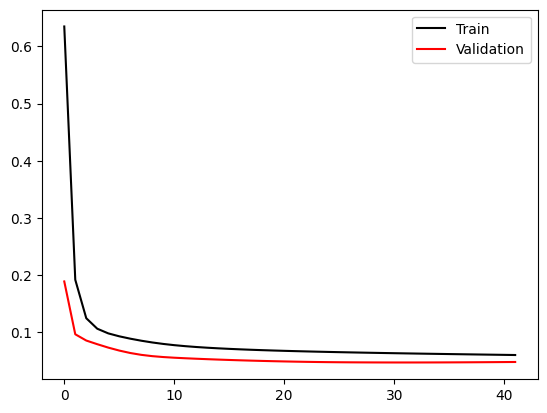

In [39]:
pd.Series(history.history['loss']).plot(style='k')
pd.Series(history.history['val_loss']).plot(style='r')
plt.legend(['Train', 'Validation'])

In [40]:
result = model.predict([test_people, test_temperature, one_hot[-len(test_people):]])[-1]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [41]:
print(result)

[0.8662781]


In [42]:
result = [result[-1], result[-1]]

In [43]:
result = np.array(result)

In [44]:
result = scaler.inverse_transform(result.reshape(1, -1))

In [45]:
print(result[0][0])

17660.562


In [46]:
res = np.array([test_y.iloc[-1], test_y.iloc[-1]])
res = scaler.inverse_transform(res.reshape(1, -1))
print(res[0][0])

12751.0


In [47]:
result = model.predict([test_people, test_temperature, one_hot[-len(test_people):]])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [48]:
def plot_forecast(test_y, result, index=index):
    plt.plot(index, test_y, label='actual')
    plt.plot(index, result, label='forecast')
    plt.legend()
    plt.show()

In [49]:
test_y_ex = np.array([test_y, test_y])

In [50]:
test_y_ex = np.array(test_y_ex.T)

In [51]:
print(test_y_ex.shape)

(485, 2)


In [52]:
test_y = scaler.inverse_transform(test_y_ex)

In [53]:
print(test_y[:, 0])

[ 3910.  4031.  5807.  7202.  9444. 12798. 13134. 14116. 12800. 11388.
 12411. 12229.  7530.  5348.  6680.  6431.  4717.  4047.  4305.  3997.
  3988.  2295.  2416.  3753.  4170.  5492.  6024.  9016. 11629. 14193.
 10913.  8191.  8577.  8610. 10059.  8373.  7772.  6518.  5768.  4958.
  4763.  4491.  4530.  4496.  4118.  2921.  3301.  3335.  4942.  9130.
 10375. 11173. 14430. 16136. 16037. 17111. 16096. 14379. 14793. 14239.
 11939.  9600.  7850.  6463.  5443.  5165.  4924.  4764.  4872.  3292.
  3673.  3958.  5875.  9780. 11876. 12144. 13215. 14322. 18572. 19070.
 18182. 17352. 17554. 16795. 13224. 10401.  7993.  6648.  5902.  5706.
  5297.  5378.  5059.  4250.  4915.  5103.  6708. 12076. 15013. 15057.
 17617. 20683. 23015. 22104. 23203. 23976. 24702. 21751. 22529. 15821.
  9768.  7091.  6484.  7109.  7739.  7487.  7342.  6571.  7518.  7702.
  9944. 13593. 16188. 20538. 22418. 26811. 27704. 23078. 22956. 23848.
 21624. 18722. 16849. 14199. 10909.  8326.  7096.  6627.  6548.  6438.
  6044

In [54]:
result = np.array([result[:, 0], result[:, 0]])

In [55]:
result = result.T
print(result.shape)

(485, 2)


In [56]:
result = scaler.inverse_transform(result)

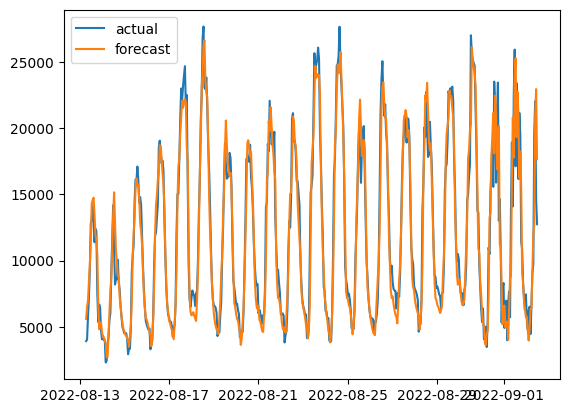

In [57]:
plot_forecast(test_y[:, 0], result[:, 0])

In [58]:
def plot_error(test_y, result):
    error = test_y - result
    plt.plot(index, error, label='error')
    plt.title(f'Error MAE: {np.mean(np.abs(error)):.2f} RMSE: {np.sqrt(np.mean(error**2)):.2f}')
    plt.legend()
    plt.show()

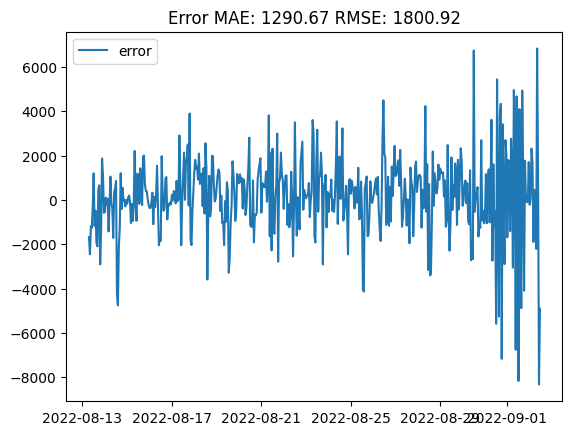

In [59]:
plot_error(test_y[:, 0], result[:, 0])